In [4]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
cols = ['sr','count','hate_speech','offensive_language','neither','class','tweet']
df = pd.read_csv("./Easydata/labeled_data.csv",header=None, names=cols)
df = df.drop(['sr','count','hate_speech','offensive_language','neither'],axis = 1)
df = df.drop(df.index[0],axis = 0)
df.head()

,class,tweet
1,2,!!! RT @mayasolovely: As a woman you shouldn't...
2,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
3,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
4,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
5,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
output = np.array(df['class'],dtype=int)
tweet = np.array(df['tweet'],dtype= str)
df1 = pd.DataFrame([output,tweet])
df = df1.T
df.columns = ['output','tweet']

In [6]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [7]:
print ("Cleaning and parsing the tweets")
cleaning = df.iloc[:,1]
result = []
for t in cleaning:
    result.append(tweet_cleaner(t))
result
print ("Cleaning Finished")
df['text'] = result



Cleaning and parsing the tweets
Cleaning Finished


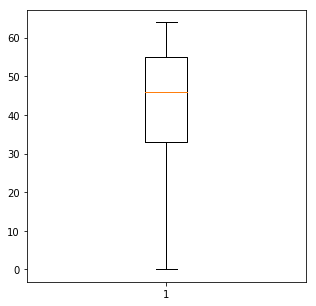

count    24783.000000
mean        43.265706
std         14.964423
min          0.000000
25%         33.000000
50%         46.000000
75%         55.000000
max         64.000000
Name: clean_len, dtype: float64

In [8]:
df['clean_len'] = [len(t) for t in df.text]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.clean_len)
plt.show()
df.clean_len.describe()

In [35]:
maxcount = 0
shape = np.shape(df1.text)
for i in range(shape[0]):
    line = df1.text[i]
    count = len(re.findall(r'\w+', line))
    maxcount = count if count > maxcount else maxcount
print ('Maximum number of words in a line is ' + str(maxcount))


Maximum number of words in a line is 19


## Common Words in Hate Speech 

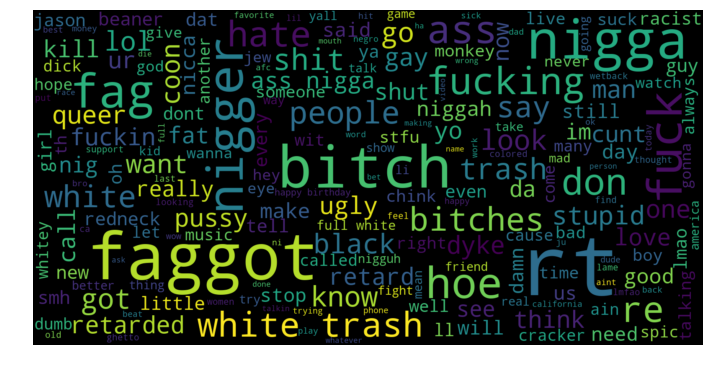

In [9]:
neg_tweets = df[df.output == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Common Words in Offensive Speech 

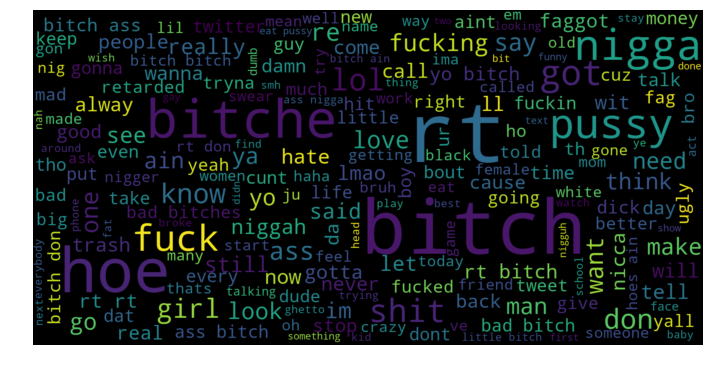

In [10]:
neu_tweets = df[df.output == 1]
neu_string = []
for t in neu_tweets.text:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Other Words 

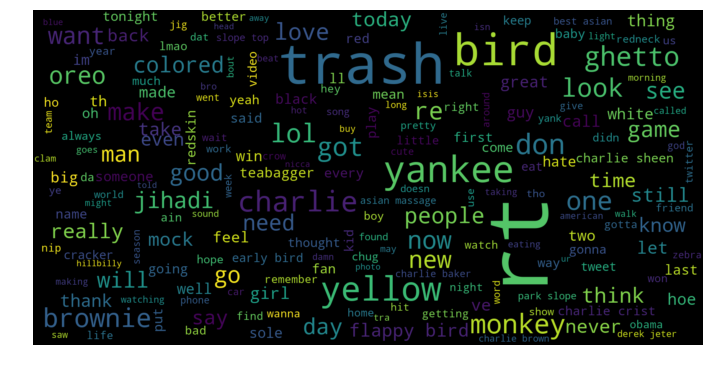

In [11]:
nei_tweets = df[df.output == 2]
nei_string = []
for t in nei_tweets.text:
    nei_string.append(t)
nei_string = pd.Series(nei_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(nei_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
df1 = df[['output','text']]

## WORD2VEC

In [13]:
df1.text

0            rt as a woman you shouldn t complain about cl
1           rt boy dats cold tyga dwn bad for cuffin dat h
2                                   rt dawg rt you ever fu
3               rt g anderson based she look like a tranny
4                        rt the shit you hear about me mig
5                 madison x the shit just blows me claim y
6        brighterdays i can not just sit up and hate on...
7                     cause i m tired of you big bitches c
8               you might not get ya bitch back thats that
9                    hobbies include fighting mariam bitch
10       keeks is a bitch she curves everyone lol i wal...
11                          murda gang bitch its gang land
12              so hoes that smoke are losers yea go on ig
13               bad bitches is the only thing that i like
14                                     bitch get up off me
15                             bitch nigga miss me with it
16                                      bitch plz whatev

tok_corp = [df1['text'].str.split(' ', expand=True).stack().unique()]
import nltk
import gensim
from gensim import corpora, models, similarities
corpus = df1['text'].values.tolist() 
#tok_corp= [nltk.word_tokenize(sent.decode('utf-8')) for sent in corpus]                  
model = gensim.models.Word2Vec(tok_corp, min_count=1, size = 32)
#model.save('testmodel')
#model = gensim.models.Word2Vec.load('test_model')
#model.most_similar('word')
#model.most_similar([vector])

In [14]:
import bcolz
import pickle
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='./Datfile/6B.50.dat', mode='w')

with open('./Datfile/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir='./Datfile/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open('./Datfile/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open('./Datfile/6B.50_idx.pkl', 'wb'))

In [15]:
vectors = bcolz.open('./Datfile/6B.50.dat')[:]
words = pickle.load(open('./Datfile/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open('./Datfile/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [16]:
glove['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [48]:
target_vocab = df1['text'].str.split(' ', expand=True).stack().unique()
matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0
words_added = 0
for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        words_added += 1
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))
        
words_found+words_added-np.size(target_vocab)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
myglove = {w: weight_matrix[i] for w in words }
target_vocab = df1['text'].str.split(' ', expand=True).stack().unique()
matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0
words_added = 0
#glove = {w: vectors[word2idx[w]] for w in words}
for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))
        words_added += 1

In [18]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class ToyNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        
    def forward(self, inp, hidden):
        return self.gru(self.embedding(inp), hidden)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [20]:
# 5. Create a Model  
model = torchvision.models.resnet18(pretrained=True)
num_chan_conv1 = model.conv1.out_channels
model.conv1 = nn.Linear(1,num_chan_conv1)
num_ftrs_fc = model.fc.in_features
model.fc = nn.Linear(num_ftrs_fc,3)
model

ResNet(
  (conv1): Linear(in_features=1, out_features=64, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3

In [52]:
from PIL import Image
arr = np.array([0]*50*19,dtype=float)
arr.resize(50,19)
qaz = df1.text[1]
qazz = qaz.split()
qazz
t = 0
for i in qazz:
    arr[:,t] = list(glove[i])
    t = t+1
Im = Image.fromarray(arr,mode='L')
Im.show()

In [54]:
np.shape(weights_matrix)


myglove = {}
keys = range(4)
values = ["Hi", "I", "am", "John"]
for i in keys:
        dicts[i] = values[i]
print(dicts)

(17555, 50)